# Packages

In [68]:
from sklearn.datasets import load_wine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from keras.models import Sequential, model_from_json
from keras.layers import Activation, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
import itertools
from tensorboard import notebook
import datetime
from sklearn.preprocessing import StandardScaler

# Data

In [69]:
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target_class'] = data.target 
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


# Data standardization

In [70]:
features = df.columns.difference(['Target_class']).tolist()
features

['alcalinity_of_ash',
 'alcohol',
 'ash',
 'color_intensity',
 'flavanoids',
 'hue',
 'magnesium',
 'malic_acid',
 'nonflavanoid_phenols',
 'od280/od315_of_diluted_wines',
 'proanthocyanins',
 'proline',
 'total_phenols']

In [71]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

let's check the scale

In [72]:
df_melt = pd.melt(df, id_vars=['Target_class'], value_vars=features)
df_melt.head()

,Target_class,variable,value
0,0,alcalinity_of_ash,-1.169593
1,0,alcalinity_of_ash,-2.490847
2,0,alcalinity_of_ash,-0.268738
3,0,alcalinity_of_ash,-0.809251
4,0,alcalinity_of_ash,0.451946


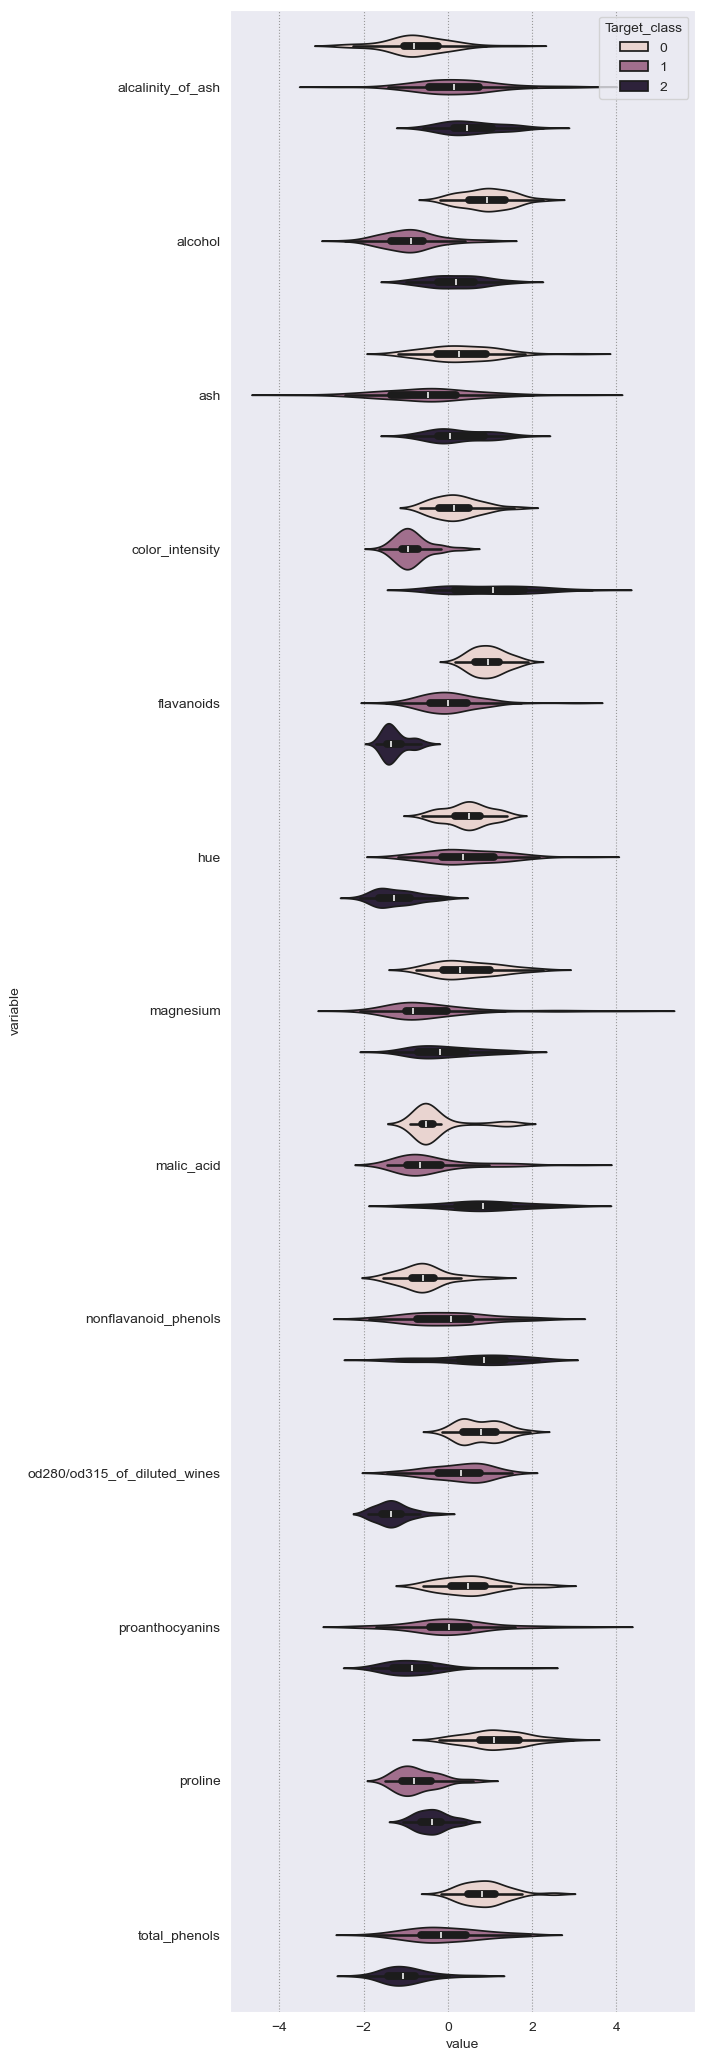

In [73]:
plt.figure(figsize=(6,26))
sns.violinplot(data = df_melt, y='variable',x='value',hue='Target_class')
plt.show()

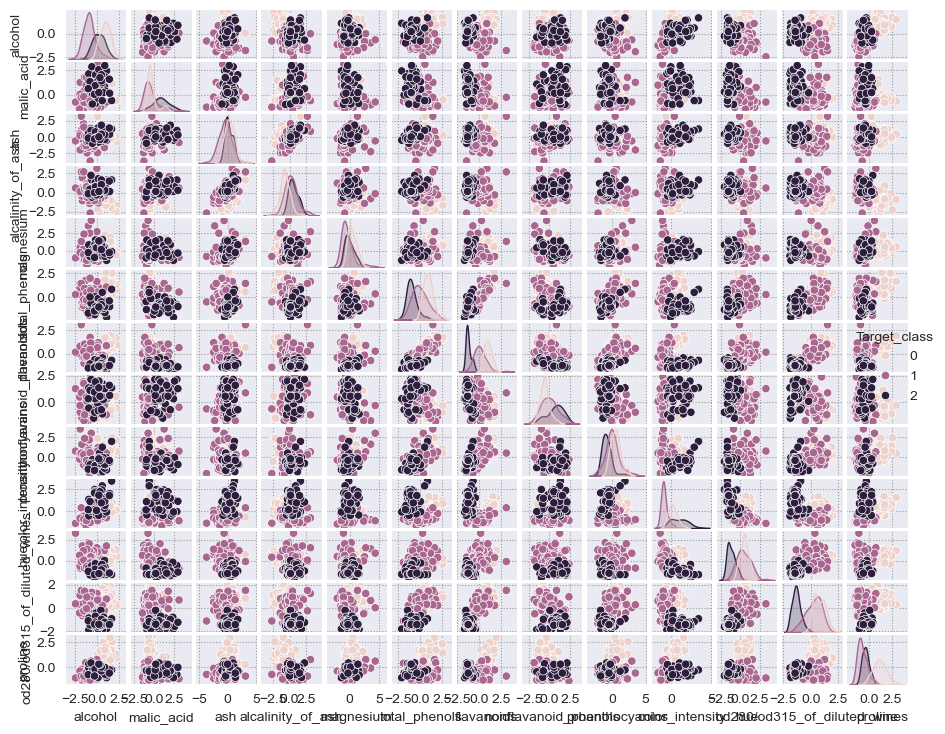

In [74]:
# pairplot

g = sns.pairplot(df, hue="Target_class")
g.fig.set_size_inches(9,7)

In [75]:
def plot_confusion_matrix(cm: np.ndarray,
                          target_names: list,
                          title: str='Confusion matrix',
                          cmap: str=None,
                          normalize: bool=True):
    '''given a sklearn confusion matrix (cm), make a nice plot

    Args:
        cm:           confusion matrix from sklearn.metrics.confusion_matrix

        target_names: given classification classes such as [0, 1, 2]
                      the class names, for example: ['high', 'medium', 'low']

        title:        the text to display at the top of the matrix

        cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                      see http://matplotlib.org/examples/color/colormaps_reference.html
                      plt.get_cmap('jet') or plt.cm.Blues

        normalize:    If False, plot the raw numbers
                      If True, plot the proportions
    '''

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Clustering sin PCA

In [76]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [77]:
import warnings
warnings.filterwarnings('ignore')

n_clusters: determina el número K
  de clusters a generar.

init: estrategia para asignar los centroides iniciales. Por defecto, se utiliza 'k-means++', una estrategia que intenta alejar los centroides lo máximo posible, facilitando la convergencia. Sin embargo, esta estrategia puede ralentizar el proceso cuando hay muchos datos, si esto ocurre, es mejor utilizar 'random'.

n_init: determina el número de veces que se repetirá el proceso, cada vez con una asignación aleatoria inicial diferente. Se recomienda que este último valor sea alto, entre 10-25, para no obtener resultados subóptimos debido a un inicio desafortunado del proceso.

max_iter: número máximo de iteraciones permitidas.

random_state: semilla para garantizar la reproducibilidad de los resultados.

In [78]:
X = df[features].values
y = df['Target_class'].values

n_clusters = 10
# model_kmeans =  KMeans(n_clusters=n_clusters , n_init=25, random_state=123)
# model_kmeans.fit(X=X)

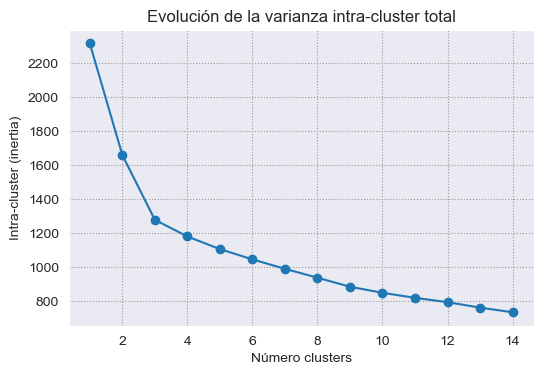

In [79]:
# elbow method
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    model_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    model_kmeans.fit(X)
    inertias.append(model_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

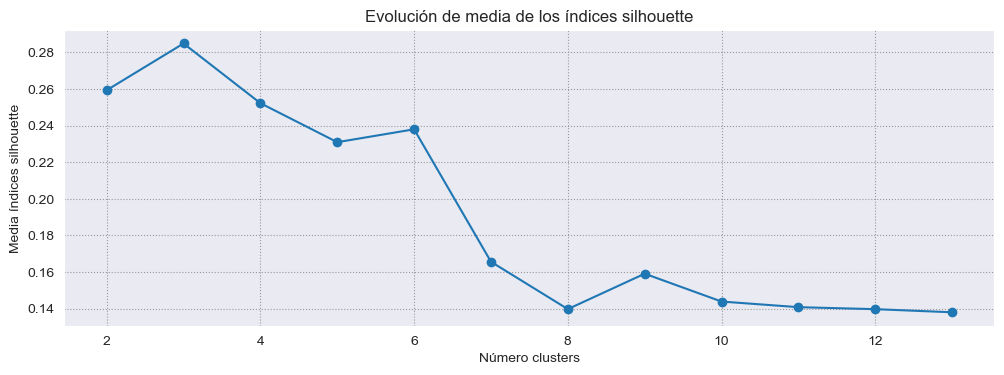

In [80]:
range_n_clusters = range(2, n_clusters)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

In [81]:
def plot_orig_predic(X,y, y_predict):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Grupos originales
    for i in np.unique(y):
        ax[0].scatter(
            x = X[y == i, 0],
            y = X[y == i, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            marker    = 'o',
            edgecolor = 'black', 
            label= f"Grupo {i}"
        )
        
    ax[0].set_title('Original Classes')
    ax[0].legend();

    for i in np.unique(y_predict):
        ax[1].scatter(
            x = X[y_predict == i, 0],
            y = X[y_predict == i, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
            marker    = 'o',
            edgecolor = 'black', 
            label= f"Cluster {i}"
        )
        
    ax[1].scatter(
        x = model_kmeans.cluster_centers_[:, 0],
        y = model_kmeans.cluster_centers_[:, 1], 
        c = 'black',
        s = 200,
        marker = '*',
        label  = 'centroides'
    )
    ax[1].set_title('KMeans Clusters')
    ax[1].legend();

## kmeans k=2

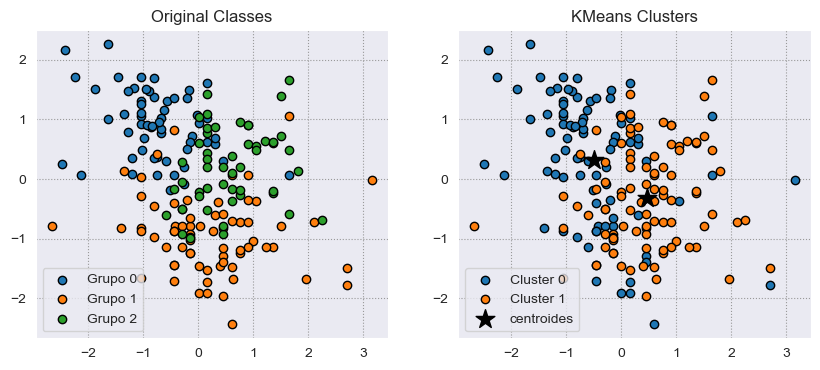

In [82]:
model_kmeans =  KMeans(n_clusters=2 , n_init=25, random_state=123)
model_kmeans.fit(X=X)
y_predict = model_kmeans.predict(X)
plot_orig_predic(X,y,y_predict)

## kmeans = 3

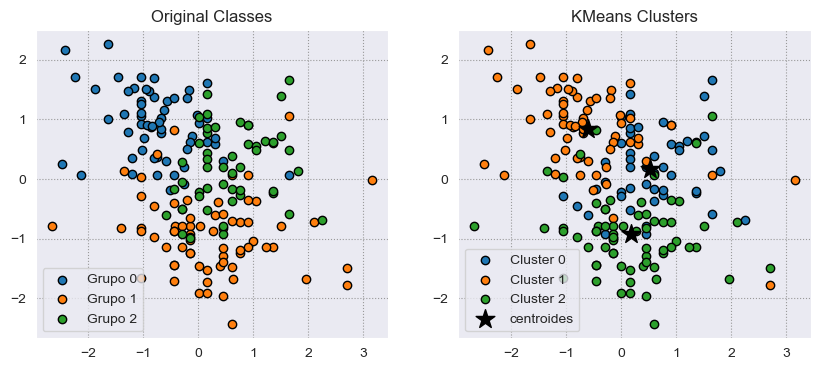

In [83]:
model_kmeans =  KMeans(n_clusters=3 , n_init=25, random_state=123)
model_kmeans.fit(X=X)
y_predict = model_kmeans.predict(X)
plot_orig_predic(X,y,y_predict)

# Con PCA

El análisis de componentes principales (ACP) es un método de reducción de la dimensionalidad que simplifica la complejidad de los espacios multidimensionales preservando su información.

**Número óptimo de componentes principales**

 Una forma de proceder muy extendida consiste en evaluar la proporción de varianza explicada y seleccionar el número mínimo de componentes a partir del cual el aumento deja de ser sustancial.

In [84]:
from sklearn.decomposition import PCA

In [85]:
model_PCA = PCA(n_components=D)
model_PCA.fit(df[features])

PCA(n_components=13)

la varianza entre de cada features da aprox 1 porque están los datos estandarizados

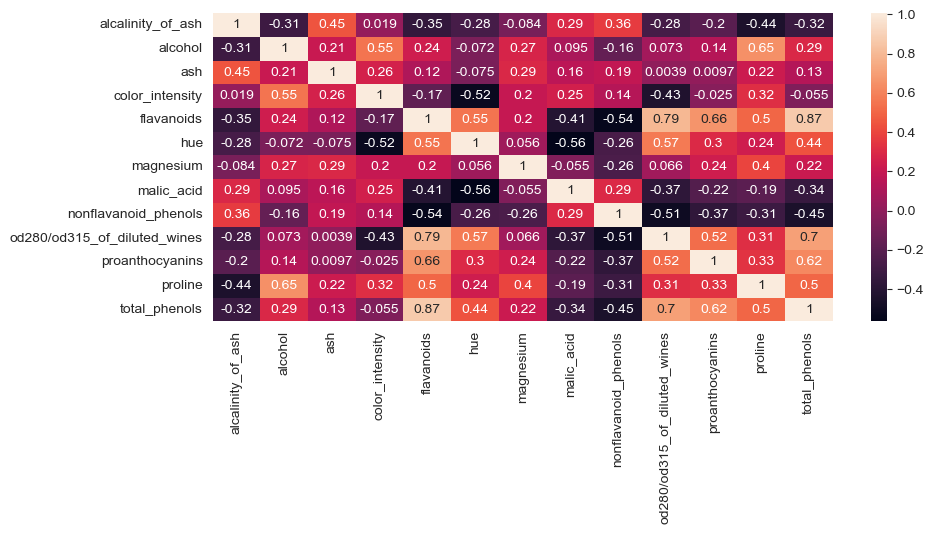

In [92]:
# Calculo usando numpy
cov_matrix = df[features].cov()

plt.figure(figsize=(10,4))
sns.heatmap(cov_matrix, annot=True)
plt.show()

**model_PCA.components_ retorna ya los vectores propios ordenados de mayor a menor valor propio**

## Paso 1: Determinar el número de componentes principales

Los valores propios estan asociados a los features, esta relación es la que podemos usar para ordenar
los vectores propios

In [93]:
eig_values, eig_vectors = np.linalg.eig(cov_matrix.values)

In [94]:
valores_propios = pd.DataFrame(
    {
        'valores propios' : eig_values,
        'Features' : df[features].columns
    }
)

valores_propios.sort_values(by='valores propios', ascending=False, inplace=True)

features_ordenadas_valores_propios = valores_propios.Features.tolist()

valores_propios

,valores propios,Features
0,4.732437,alcalinity_of_ash
1,2.511081,alcohol
2,1.454242,ash
3,0.924166,color_intensity
4,0.858049,flavanoids
5,0.645282,hue
6,0.554141,magnesium
8,0.350466,nonflavanoid_phenols
10,0.290512,proanthocyanins
12,0.252320,total_phenols


In [95]:
vectores_propios = pd.DataFrame(
    data    = eig_vectors,
    columns = df[features].columns,
    index   = [f'PC{i}' for i in range(1,D+1)]
)

# ordenamos la matriz de mayor a menor valor propio
vectores_propios = vectores_propios[features_ordenadas_valores_propios].copy()
# transponemos 
vectores_propios = vectores_propios.T
vectores_propios

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
alcalinity_of_ash,-0.239320,0.144329,-0.002051,-0.088617,0.422934,0.296715,0.141992,-0.245188,-0.298533,0.376167,0.313429,0.286752,0.394661
alcohol,0.010591,-0.483652,-0.316069,-0.529996,0.003360,0.279235,-0.299634,-0.224931,-0.028779,0.164496,-0.039302,-0.364903,-0.065040
ash,0.612080,-0.207383,0.626224,-0.137306,0.150682,0.085222,0.130757,0.089013,0.170368,0.166005,0.149454,-0.126746,0.146179
color_intensity,0.060859,-0.017856,-0.214176,0.065926,0.152295,-0.427771,-0.351797,0.536890,-0.203301,0.184121,0.399057,-0.232071,0.198068
flavanoids,0.066103,-0.265664,-0.143025,-0.076437,-0.109026,-0.173615,0.727049,0.035214,-0.500703,-0.101161,0.136860,-0.157869,-0.149318
hue,0.100825,-0.213539,-0.154475,0.418644,0.018920,-0.105983,-0.038144,-0.536814,0.258594,-0.265851,0.533795,-0.119726,0.084122
magnesium,0.286969,0.056396,0.149171,0.227712,0.060685,-0.232076,-0.322883,-0.420524,-0.595447,0.044764,-0.372139,-0.076805,0.027925
nonflavanoid_phenols,0.427970,0.396139,-0.170260,-0.033797,-0.187245,0.436624,-0.156361,0.065827,-0.233285,-0.078108,0.368227,0.120023,-0.405934
proanthocyanins,-0.200449,-0.508619,0.307694,-0.056218,-0.049578,-0.085828,-0.271403,0.075283,-0.195501,-0.137227,0.209145,0.575786,-0.286035
total_phenols,-0.052799,-0.211605,0.027125,0.290775,0.163151,0.522399,-0.067870,0.309080,-0.215535,-0.523706,-0.134184,-0.162116,0.320131


In [96]:
# esta seria la forma correcta para analizar los datos
pd.DataFrame(
    data    = model_PCA.components_,
    columns = [f'PC{i}' for i in range(1,D+1)],
    index   = features_ordenadas_valores_propios
)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
alcalinity_of_ash,-0.239320,0.144329,-0.002051,-0.088617,0.422934,0.296715,0.141992,-0.245188,-0.298533,0.376167,0.313429,0.286752,0.394661
alcohol,-0.010591,0.483652,0.316069,0.529996,-0.003360,-0.279235,0.299634,0.224931,0.028779,-0.164496,0.039302,0.364903,0.065040
ash,0.612080,-0.207383,0.626224,-0.137306,0.150682,0.085222,0.130757,0.089013,0.170368,0.166005,0.149454,-0.126746,0.146179
color_intensity,0.060859,-0.017856,-0.214176,0.065926,0.152295,-0.427771,-0.351797,0.536890,-0.203301,0.184121,0.399057,-0.232071,0.198068
flavanoids,0.066103,-0.265664,-0.143025,-0.076437,-0.109026,-0.173615,0.727049,0.035214,-0.500703,-0.101161,0.136860,-0.157869,-0.149318
hue,-0.100825,0.213539,0.154475,-0.418644,-0.018920,0.105983,0.038144,0.536814,-0.258594,0.265851,-0.533795,0.119726,-0.084122
magnesium,-0.286969,-0.056396,-0.149171,-0.227712,-0.060685,0.232076,0.322883,0.420524,0.595447,-0.044764,0.372139,0.076805,-0.027925
nonflavanoid_phenols,0.427970,0.396139,-0.170260,-0.033797,-0.187245,0.436624,-0.156361,0.065827,-0.233285,-0.078108,0.368227,0.120023,-0.405934
proanthocyanins,-0.200449,-0.508619,0.307694,-0.056218,-0.049578,-0.085828,-0.271403,0.075283,-0.195501,-0.137227,0.209145,0.575786,-0.286035
total_phenols,0.052799,0.211605,-0.027125,-0.290775,-0.163151,-0.522399,0.067870,-0.309080,0.215535,0.523706,0.134184,0.162116,-0.320131


In [97]:
# reseteo el index
valores_propios.reset_index(inplace=True)
total = valores_propios['valores propios'].sum()
valores_propios['Proporción'] = valores_propios['valores propios']/total
valores_propios['Acumulada']  = valores_propios['Proporción'].cumsum()

valores_propios['Componentes'] = valores_propios.index + 1
valores_propios

,index,valores propios,Features,Proporción,Acumulada,Componentes
0,0,4.732437,alcalinity_of_ash,0.361988,0.361988,1
1,1,2.511081,alcohol,0.192075,0.554063,2
2,2,1.454242,ash,0.111236,0.665300,3
3,3,0.924166,color_intensity,0.070690,0.735990,4
4,4,0.858049,flavanoids,0.065633,0.801623,5
5,5,0.645282,hue,0.049358,0.850981,6
6,6,0.554141,magnesium,0.042387,0.893368,7
7,8,0.350466,nonflavanoid_phenols,0.026807,0.920175,8
8,10,0.290512,proanthocyanins,0.022222,0.942397,9
9,12,0.252320,total_phenols,0.019300,0.961697,10


**En Minitab mencionan**: "Valores propios
Usted puede utilizar el tamaño del valor propio para determinar el número de componentes principales. Conserve los componentes principales con los valores propios más grandes. Por ejemplo, según el criterio de Kaiser, se usan solo los componentes principales con valores propios que son mayores que 1."

Para este ejercicio los valores propios asociados a los features "alcalinity_of_ash", "alcohol" y "ash" son aquellos con valores por encima de 1.

En estos resultados, los tres primeros componentes principales tienen valores propios mayores que 1. Estos tres componentes explican 67% de la variación en los datos. La gráfica de sedimentación muestra que los valores propios comienzan a formar una línea recta después del tercer componente principal. Si 67% es una cantidad adecuada de variación explicada en los datos, entonces se deben utilizar los tres primeros componentes principales.

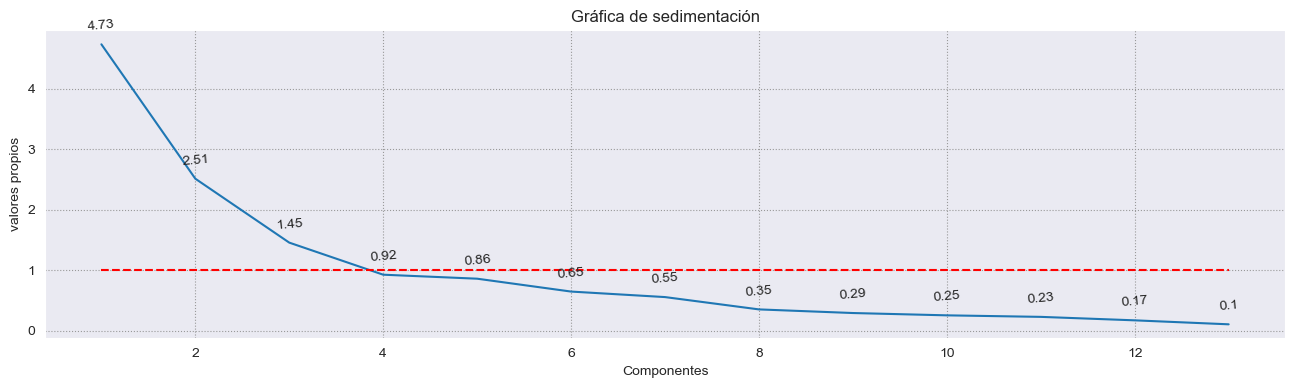

In [98]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

for x, y, z in zip(np.arange(valores_propios.shape[0]) + 1, valores_propios['valores propios'], valores_propios['valores propios']):
    label = str(round(z,2))
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        rotation=5
    )

sns.lineplot(
    valores_propios, x='Componentes', y='valores propios'
)

plt.hlines(y=1,xmin=1, xmax=valores_propios.shape[0],color='red', linestyles='--')
plt.title('Gráfica de sedimentación')
plt.show()

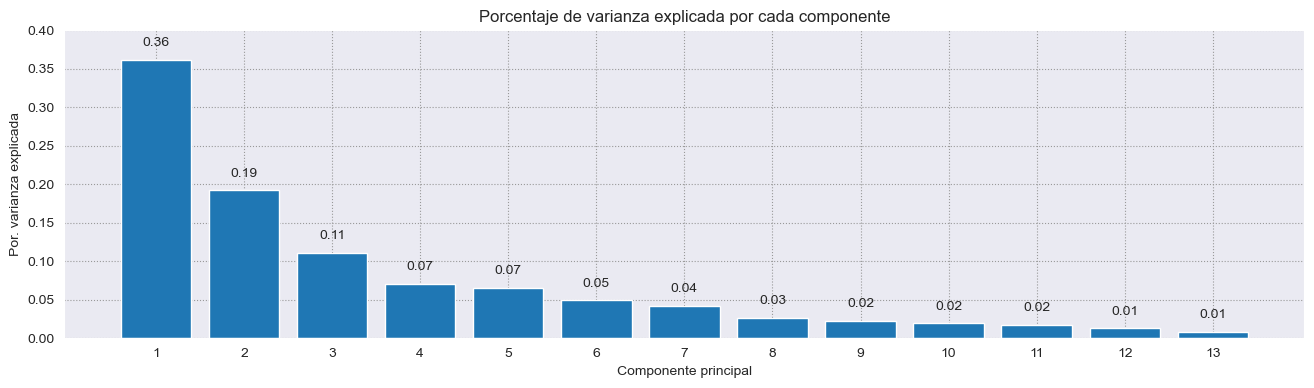

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.bar(
    x      = np.arange(valores_propios.shape[0]) + 1,
    height = valores_propios['Proporción']
)

for x, y in zip(np.arange(valores_propios.shape[0]) + 1, valores_propios['Proporción']):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(valores_propios.shape[0]) + 1)
ax.set_ylim(0, 0.4)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

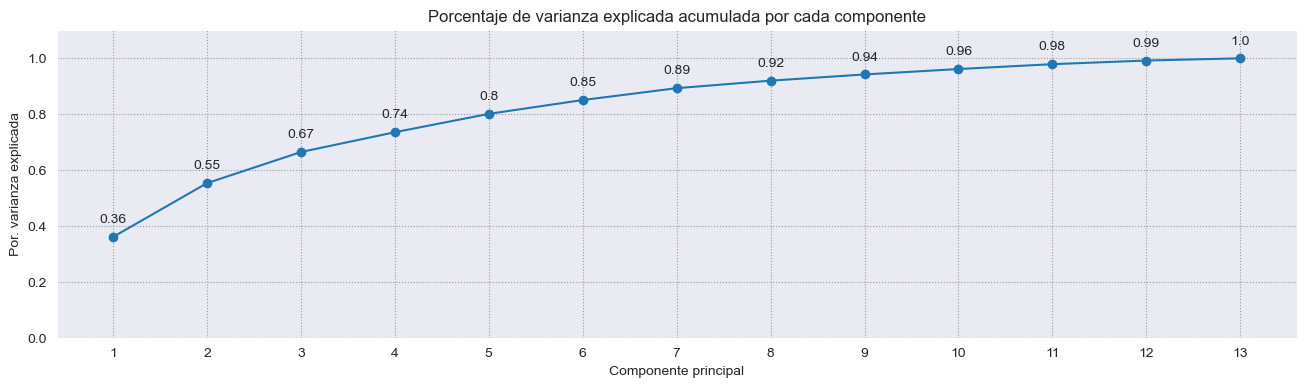

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.plot(
    np.arange(valores_propios.shape[0]) + 1,
    valores_propios['Acumulada'],
    marker = 'o'
)

for x, y in zip(np.arange(valores_propios.shape[0]) + 1, valores_propios['Acumulada']):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(valores_propios.shape[0]) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada acumulada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

## Paso 2: Interpretar cada componente principal en términos de las variables originales

Estos datos son los resultados de un análisis químico de vinos cultivados en la misma región de Italia pero procedentes de tres variedades diferentes.

Alcohol: Porcentaje de alcohol en el vino.

Malic acid: Contenido de ácido málico, un ácido orgánico que contribuye a la acidez del vino.

Ash: Contenido de cenizas, que indica la cantidad de minerales inorgánicos presentes.

Alcalinity of ash: Alcalinidad de las cenizas, relacionada con el contenido de potasio.

Magnesium: Contenido de magnesio, un mineral esencial para las plantas y, por lo tanto, presente en la uva.

Total phenols: Contenido total de fenoles, compuestos antioxidantes que influyen en el color y el sabor del vino.

Flavanoids: Subtipo de fenoles que aportan color y astringencia.

Nonflavanoid phenols: Otro subtipo de fenoles.

Proanthocyanins: También conocidos como taninos condensados, contribuyen a la astringencia y estructura del vino.

Color intensity: Intensidad del color del vino, medida de forma visual o espectrofotométrica.

Hue: Tono del color, que indica la proporción de rojo y amarillo.

OD280/OD315 of diluted wines: Relación entre la absorbancia a 280 y 315 nm del vino diluido, una medida utilizada para evaluar la madurez fenólica.

Proline: Aminoácido presente en el vino, relacionado con la madurez de la uva.

In [101]:
vectores_propios.loc[['alcalinity_of_ash','alcohol','ash'],['PC1','PC2','PC3']]

,PC1,PC2,PC3
alcalinity_of_ash,-0.239320,0.144329,-0.002051
alcohol,0.010591,-0.483652,-0.316069
ash,0.612080,-0.207383,0.626224


In [102]:
valores_propios.loc[valores_propios['Features'].isin(['alcalinity_of_ash','alcohol','ash']),['Features','valores propios']]

,Features,valores propios
0,alcalinity_of_ash,4.732437
1,alcohol,2.511081
2,ash,1.454242


Para interpretar cada componente principal, examine la magnitud y la dirección de los coeficientes de las variables originales. Cuanto mayor sea el valor absoluto del coeficiente, más importante será la variable correspondiente en el cálculo del componente. Qué tan grande debe ser el valor absoluto de un coeficiente para ser considerado importante es subjetivo. Utilice su conocimiento especializado para determinar en qué nivel el valor de correlación es importante.

In [103]:
vectores_propios.loc[vectores_propios.index[0:3],'PC1'].sort_values(ascending=False)

ash                  0.612080
alcohol              0.010591
alcalinity_of_ash   -0.239320
Name: PC1, dtype: float64

In [104]:
vectores_propios.loc[vectores_propios.index[0:3],'PC2'].sort_values(ascending=False)

alcalinity_of_ash    0.144329
ash                 -0.207383
alcohol             -0.483652
Name: PC2, dtype: float64

In [105]:
vectores_propios.loc[vectores_propios.index[0:3],'PC3'].sort_values(ascending=False)

ash                  0.626224
alcalinity_of_ash   -0.002051
alcohol             -0.316069
Name: PC3, dtype: float64

**Se realiza la interpretacion solo con los primeros 3 componenentes.**

En estos resultados, el primer componente principal tiene asociaciones positivas grandes con el "Ash", (Contenido de cenizas, que indica la cantidad de minerales inorgánicos presentes) y asociaciones negativas grandes con "Alcalinity of ash" (Alcalinidad de las cenizas, relacionada con el contenido de potasio), así que este componente recoge principalmente información sobre el contenido de minerales inorgánicos de cada vino. 

El segundo componente principal tiene asociaciones negativas grandes con el "Alcohol", (Porcentaje de alcohol en el vino) y el "Ash", (Contenido de cenizas, que indica la cantidad de minerales inorgánicos presentes), así que este componente recoge principalmente información sobre la cantidad de alcohol de cada vino y también el contenido de minerales inorgánicos de cada vino. 

En el tercer componente ocurre algo parecido al segundo componente

En conclusión, "ash", "alcalinity_of_ash" y "alcohol" recogen la mayor parte de la información que permitirían distinguier el origen de cada variedad de vino.

[PC1, PC2]:  [-0.23932041  0.1443294 ] valor:  4.732436977583585  alcalinity_of_ash
[PC1, PC2]:  [ 0.0105905  -0.48365155] valor:  2.5110809296451246  alcohol
[PC1, PC2]:  [ 0.61208035 -0.20738262] valor:  1.454241867846468  ash


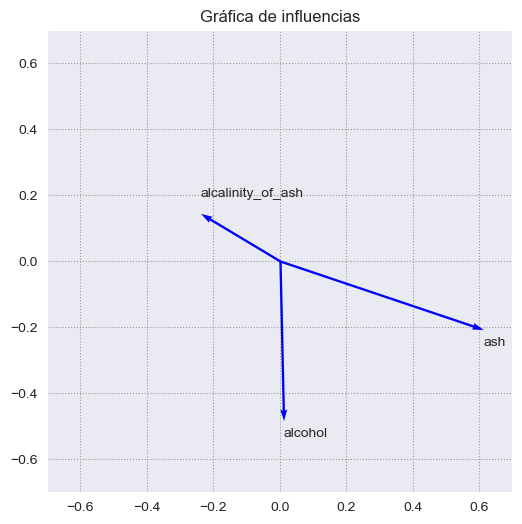

In [106]:

plt.figure(figsize=(6,6))
for f in vectores_propios.index[:3]:
    vector = vectores_propios.loc[[f],['PC1','PC2']].values.reshape(-1)
    valor  = valores_propios.loc[valores_propios['Features'].isin([f]),['valores propios']].values[0][0]
    print('[PC1, PC2]: ',vector,'valor: ', valor, f' {f}')

    # Graficando los eigenvectores
    plt.quiver(0, 0, 
            vector[0],
            vector[1],
            color="blue", angles="xy", scale_units="xy", scale=1, width=0.005
    )

    paddx = 0.05

    if vector[1] < 0:
        paddx = paddx *-1

    plt.text(
        x=vector[0] ,
        y=vector[1]+paddx ,
        s=f
    )



plt.title('Gráfica de influencias')
plt.xlim((-0.7,0.7))
plt.ylim((-0.7,0.7))
plt.show()

In [107]:
# Componentes x Features
vectores_propios.T.head()

,alcalinity_of_ash,alcohol,ash,color_intensity,flavanoids,hue,magnesium,nonflavanoid_phenols,proanthocyanins,total_phenols,proline,od280/od315_of_diluted_wines,malic_acid
PC1,-0.239320,0.010591,0.612080,0.060859,0.066103,0.100825,0.286969,0.427970,-0.200449,-0.052799,0.479314,-0.055743,-0.091683
PC2,0.144329,-0.483652,-0.207383,-0.017856,-0.265664,-0.213539,0.056396,0.396139,-0.508619,-0.211605,-0.225917,-0.266286,-0.014970
PC3,-0.002051,-0.316069,0.626224,-0.214176,-0.143025,-0.154475,0.149171,-0.170260,0.307694,0.027125,-0.498691,-0.049622,0.141218
PC4,-0.088617,-0.529996,-0.137306,0.065926,-0.076437,0.418644,0.227712,-0.033797,-0.056218,0.290775,0.031839,0.604222,0.011993
PC5,0.422934,0.003360,0.150682,0.152295,-0.109026,0.018920,0.060685,-0.187245,-0.049578,0.163151,-0.025694,-0.042899,-0.832257


Para transformar los datos previamente scalados, se multiplica el dataframe DF de dimensión MxN (filasxfeatures) por la matriz de vectores propios previamente ordenada de mayor a menor valor propio de dimension NxN (componesxFeatures)

In [108]:
df_PCA = pd.DataFrame(
    np.dot(df[features].values, vectores_propios.values.T),
    columns=[f'PC{i}' for i in range(1, len(features)+1)]
)

df_PCA

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,3.316751,-1.443463,-0.165739,-0.215631,0.693043,-0.223880,-0.596427,-0.065139,-0.641443,-1.020956,-0.451563,0.540810,0.066239
1,2.209465,0.333393,-2.026457,-0.291358,-0.257655,-0.927120,-0.053776,-1.024416,0.308847,-0.159701,-0.142657,0.388238,-0.003637
2,2.516740,-1.031151,0.982819,0.724902,-0.251033,0.549276,-0.424205,0.344216,1.177834,-0.113361,-0.286673,0.000584,-0.021717
3,3.757066,-2.756372,-0.176192,0.567983,-0.311842,0.114431,0.383337,-0.643593,-0.052544,-0.239413,0.759584,-0.242020,0.369484
4,1.008908,-0.869831,2.026688,-0.409766,0.298458,-0.406520,-0.444074,-0.416700,-0.326819,0.078366,-0.525945,-0.216664,0.079364
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,-3.370524,-2.216289,-0.342570,1.058527,-0.574164,-1.108788,-0.958416,0.146097,0.022498,0.304117,0.139228,0.170786,0.114427
174,-2.601956,-1.757229,0.207581,0.349496,0.255063,-0.026465,-0.146894,0.552427,0.097969,0.206061,0.258198,-0.279431,0.187371
175,-2.677839,-2.760899,-0.940942,0.312035,1.271355,0.273068,-0.679235,-0.047024,-0.001222,0.247997,0.512492,0.698766,-0.072078
176,-2.387017,-2.297347,-0.550696,-0.688285,0.813955,1.178783,-0.633975,-0.390829,-0.057448,-0.491490,0.299822,0.339821,0.021866


Cuando se validó cuántos componentes principales tenian asociados valores propios por encima de 1, se encontró que eran tres. Con tres componentes se procede a hacer la clusterización

In [109]:
proyecciones = df_PCA.copy()
proyecciones_3dim = proyecciones[['PC1','PC2', 'PC3']].copy()
proyecciones_3dim.head()

,PC1,PC2,PC3
0,3.316751,-1.443463,-0.165739
1,2.209465,0.333393,-2.026457
2,2.516740,-1.031151,0.982819
3,3.757066,-2.756372,-0.176192
4,1.008908,-0.869831,2.026688


## elbow method

In [110]:
X = proyecciones_3dim.values
n_clusters = 10

Visulamente el codo explica que el mejor k es 3

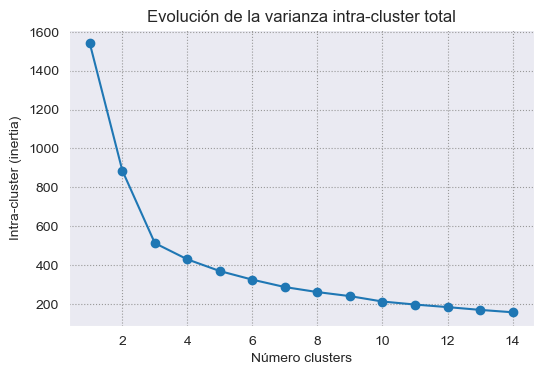

In [111]:
# elbow method
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    model_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    model_kmeans.fit(X)
    inertias.append(model_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Usando la silhouette promedio también se encuentra que el mejor k es 3

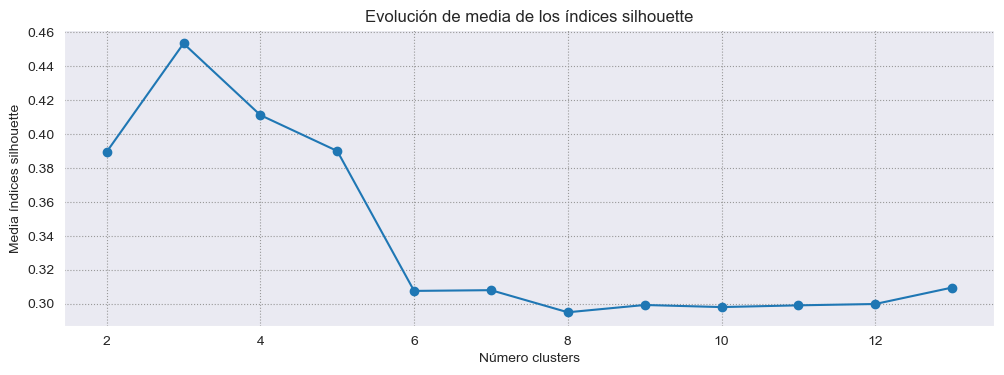

In [112]:
range_n_clusters = range(2, n_clusters)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 25, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(12, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

se usa kmeans con k=3

In [113]:
y = df['Target_class']

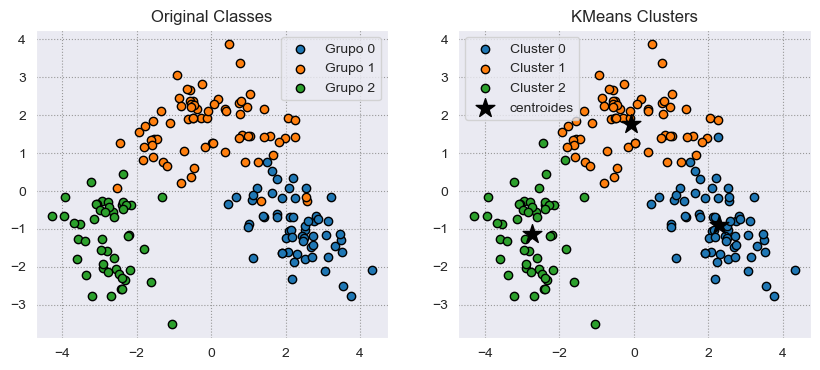

In [114]:
model_kmeans =  KMeans(n_clusters=3 , n_init=25, random_state=123)
model_kmeans.fit(X=X)
y_predict = model_kmeans.predict(X)
plot_orig_predic(X,y,y_predict)

Usando tres componentes se obtiene un accuracy de 96% comparando las clases priginales con la inferencia realizada por el kmeans

In [115]:
y_predict_adj = np.array(
    [0 if i == 0 else 1 if i == 1 else 2 for i in y_predict]
)

y_predict_adj 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

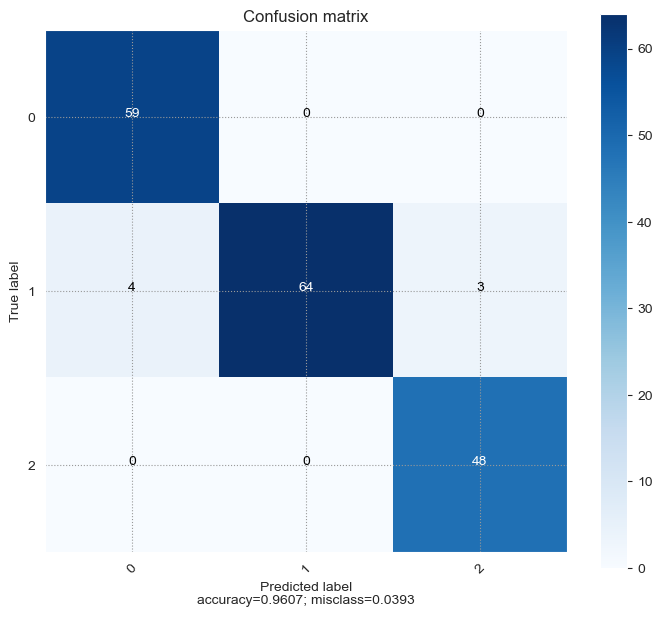

In [116]:
plot_confusion_matrix(
    cm=confusion_matrix(df['Target_class'], y_predict_adj),
    target_names=list(range(len(df['Target_class'].unique()))),
    title='Confusion matrix',
    normalize=False
    )

# webgraphy

https://cienciadedatos.net/documentos/py20-clustering-con-python

https://cienciadedatos.net/documentos/py19-pca-python

https://support.minitab.com/es-mx/minitab/help-and-how-to/statistical-modeling/multivariate/how-to/principal-components/interpret-the-results/key-results/